
# **Predicting Student Test Scores**

[Playground Series - Season 6 Episode 1](https://www.kaggle.com/competitions/playground-series-s6e1)

**Goal**: Predict students' test scores.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s6e1/sample_submission.csv
/kaggle/input/playground-series-s6e1/train.csv
/kaggle/input/playground-series-s6e1/test.csv


In [2]:
dataset = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
dataset_test = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')
LOW, HIGH = dataset['exam_score'].min(), dataset['exam_score'].max()

## **EDA**

In [3]:
print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB
None


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [4]:
print(dataset_test.info())
dataset_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                270000 non-null  int64  
 1   age               270000 non-null  int64  
 2   gender            270000 non-null  object 
 3   course            270000 non-null  object 
 4   study_hours       270000 non-null  float64
 5   class_attendance  270000 non-null  float64
 6   internet_access   270000 non-null  object 
 7   sleep_hours       270000 non-null  float64
 8   sleep_quality     270000 non-null  object 
 9   study_method      270000 non-null  object 
 10  facility_rating   270000 non-null  object 
 11  exam_difficulty   270000 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 24.7+ MB
None


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop(columns=['exam_score', 'id']), dataset["exam_score"], test_size=0.2, random_state=42
)

In [6]:
num_cols = ["age", "study_hours", "class_attendance", "sleep_hours"]
ordinal_cols = ["facility_rating", "exam_difficulty", "sleep_quality"]
categotical_cols = ["gender", "course", "internet_access", "study_method"]

facility_order = ["low", "medium", "high"]
exam_difficulty_order = ["easy", "moderate", "hard"]
sleep_quality_order = ["poor", "average", "good"]

preprocess = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('ord', OrdinalEncoder(categories=[facility_order, exam_difficulty_order, sleep_quality_order]), ordinal_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categotical_cols)
])

<Axes: >

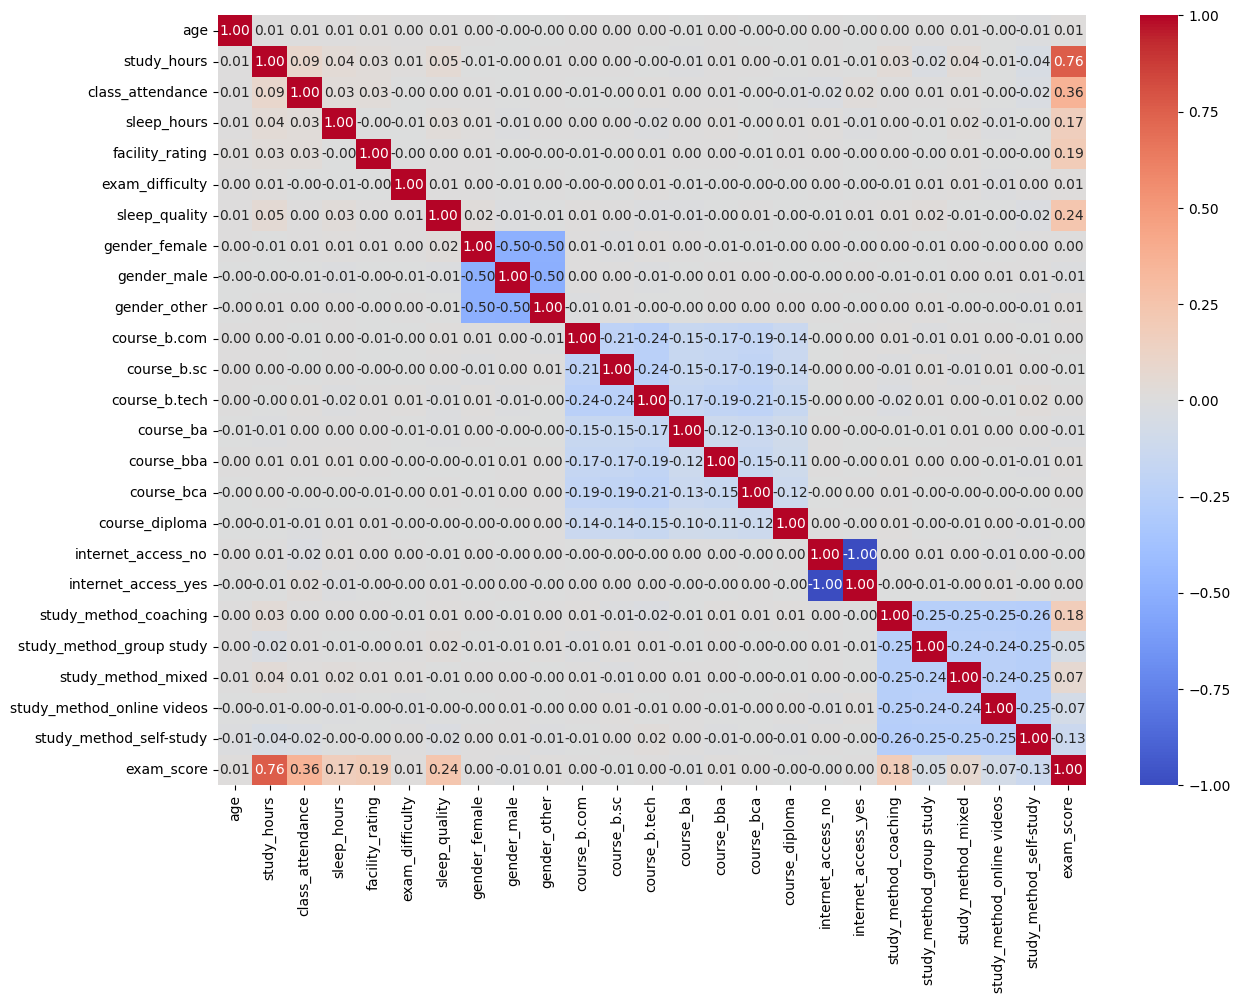

In [7]:
# Correlation heatmap to visualize relationships between features and target
dataset_transformed = preprocess.fit_transform(dataset.drop(columns=['id']))
dataset_transformed = pd.DataFrame(dataset_transformed, columns=num_cols + ordinal_cols + list(preprocess.named_transformers_['cat'].get_feature_names_out(categotical_cols)))
dataset_transformed['exam_score'] = dataset['exam_score'].values
plt.figure(figsize=(14, 10))
sns.heatmap(dataset_transformed.corr(), annot=True, fmt=".2f", cmap='coolwarm')

In [8]:
num_cols = ["study_hours", "class_attendance", "sleep_hours"]
ordinal_cols = ["facility_rating", "exam_difficulty", "sleep_quality"]
categotical_cols = ["study_method"]

facility_order = ["low", "medium", "high"]
exam_difficulty_order = ["easy", "moderate", "hard"]
sleep_quality_order = ["poor", "average", "good"]

preprocess = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('ord', OrdinalEncoder(categories=[facility_order, exam_difficulty_order, sleep_quality_order]), ordinal_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categotical_cols)
])

<Axes: >

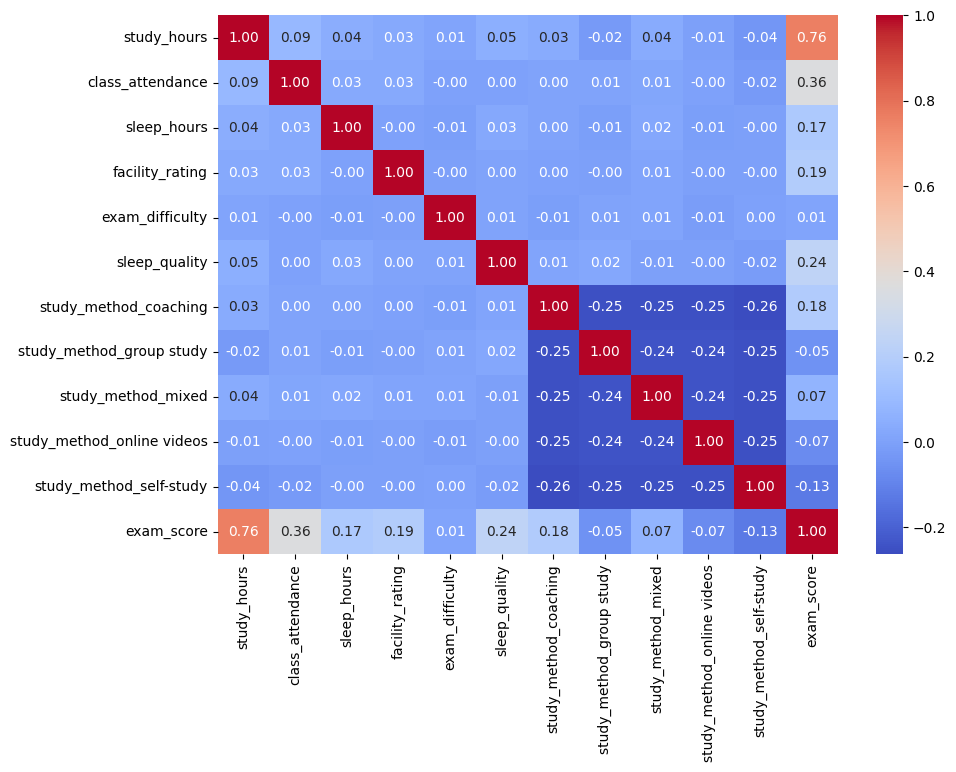

In [9]:
dataset_transformed = preprocess.fit_transform(dataset.drop(columns=['id']))
dataset_transformed = pd.DataFrame(dataset_transformed, columns=num_cols + ordinal_cols + list(preprocess.named_transformers_['cat'].get_feature_names_out(categotical_cols)))
dataset_transformed['exam_score'] = dataset['exam_score'].values
plt.figure(figsize=(10, 7))
sns.heatmap(dataset_transformed.corr(), annot=True, fmt=".2f", cmap='coolwarm')

In [10]:
#sns.pairplot(dataset_transformed)

## **Models**

- XGBoost
- SGDRegressor
- GradientBoostingRegressor

These models capture different patterns in the data, from linear relationships to complex nonlinear interactions.  To improve performance, I combine them using a Stacking Regressor, where predictions from each base model are used as inputs to a final meta-model.

In [11]:
pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', DummyRegressor())
])

param_grid_sgd = [
    {
        'model': [SGDRegressor(random_state=42)],
    }
]

param_grid_xgb = [
    {
        'model': [XGBRegressor(random_state=42)],
        'model__n_estimators': [100, 300, 600],
        'model__learning_rate': [0.04, 0.07, 0.1]
    }
]

param_grid_grad = [
    {
        'model': [GradientBoostingRegressor(random_state=42)],
    }
]

In [12]:
sgd_model = GridSearchCV(pipe, param_grid_sgd, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
sgd_model.fit(X_train, y_train)

y_pred_sgd = np.clip(sgd_model.predict(X_test), LOW, HIGH)
rmse_sgd = root_mean_squared_error(y_test, y_pred_sgd)
r2_sgd = r2_score(y_test, y_pred_sgd)

print("Best SGDRegressor Parameters:", sgd_model.best_params_)
print(f"SGDRegressor RMSE: {rmse_sgd:.4f}\nR2: {r2_sgd:.4f}")

Best SGDRegressor Parameters: {'model': SGDRegressor(random_state=42)}
SGDRegressor RMSE: 8.8841
R2: 0.7781


In [13]:
xgb_model = GridSearchCV(pipe, param_grid_xgb, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_model.fit(X_train, y_train)

y_pred_xgb = np.clip(xgb_model.predict(X_test), LOW, HIGH)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("Best XGBoost:", xgb_model.best_params_)
print(f"XGBoost RMSE: {rmse_xgb:.4f}\nR2: {r2_xgb:.4f}")

Best XGBoost: {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...), 'model__learning_rate': 0.07, 'model__n_estimators': 600}
XGBoost RMSE: 8.7509
R2: 0.7847


In [14]:
grad_model = GridSearchCV(pipe, param_grid_grad, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grad_model.fit(X_train, y_train)

y_pred_grad = np.clip(grad_model.predict(X_test), LOW, HIGH)
rmse_grad = root_mean_squared_error(y_test, y_pred_grad)
r2_grad = r2_score(y_test, y_pred_grad)

print("Best GradientBoosting Parameters:", grad_model.best_params_)
print(f"GradientBoosting RMSE: {rmse_grad:.4f}\nR2: {r2_grad:.4f}")

Best GradientBoosting Parameters: {'model': GradientBoostingRegressor(random_state=42)}
GradientBoosting RMSE: 8.8402
R2: 0.7803


In [15]:
# Combine models using Stacking Regressor
stacking = StackingRegressor(
    estimators=[
        ('sgd', sgd_model.best_estimator_),
        ('xgb', xgb_model.best_estimator_),
        ('grad', grad_model.best_estimator_),
    ],
    final_estimator=Ridge(),
    cv=5,
    n_jobs=-1,
)

# Overview of stacking model
stacking

StackingRegressor(cv=5,
                  estimators=[('sgd',
                               Pipeline(steps=[('preprocess',
                                                ColumnTransformer(transformers=[('num',
                                                                                 MinMaxScaler(),
                                                                                 ['study_hours',
                                                                                  'class_attendance',
                                                                                  'sleep_hours']),
                                                                                ('ord',
                                                                                 OrdinalEncoder(categories=[['low',
                                                                                                             'medium',
                                                                                                             'high'],
                                                                                                            ['easy',
                                                                                                             'moderate',
                                                                                                             'hard'],
                                                                                                            ['poor',
                                                                                                             'average',
                                                                                                             'good']]),
                                                                                 ['facility_rating',
                                                                                  'exam_difficulty',
                                                                                  'sleep_quality']),
                                                                                ('cat'...
                                                                                  'class_attendance',
                                                                                  'sleep_hours']),
                                                                                ('ord',
                                                                                 OrdinalEncoder(categories=[['low',
                                                                                                             'medium',
                                                                                                             'high'],
                                                                                                            ['easy',
                                                                                                             'moderate',
                                                                                                             'hard'],
                                                                                                            ['poor',
                                                                                                             'average',
                                                                                                             'good']]),
                                                                                 ['facility_rating',
                                                                                  'exam_difficulty',
                                                                                  'sleep_quality']),
                                                                                ('cat',
                                                                                 OneHotEncoder(handl

In [16]:
stacking.fit(X_train, y_train)
y_pred_stack = np.clip(stacking.predict(X_test), LOW, HIGH)
rmse_stacking = root_mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test, y_pred_stack)

print(f"Stacking RMSE: {rmse_stacking:.4f}\nR2: {r2_stacking:.4f}")

Stacking RMSE: 8.7496
R2: 0.7847


## **Predictions**

In [17]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s6e1/sample_submission.csv')
preds = np.clip(stacking.predict(dataset_test), LOW, HIGH)

sample_submission['exam_score'] = preds
sample_submission.to_csv('submission.csv', index=False)